# MMLU Benchmark

> Evaluate Llama models using MMLU

# Parameters

In [3]:
n_iterations = 3
n_questions = 25
n_shots = 0
max_sequence_len = 1000
checkpoint = "Llama3.2-3B-Instruct"

# Setup

In [17]:
# Imports
import logging
from logging import StreamHandler, Formatter
import os
from pathlib import Path
from random import sample
import sys
from typing import Iterator

from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from tqdm.auto import trange, tqdm

from llama_kit.model import load_config, load_parameters, load_tokenizer, render_prompt, unpack_parameters, LlamaHead, LlamaModel, ModelConfig
from llama_kit.benchmarks.mmlu import (
    Dataset,
    load_dataset, 
    display_questions, 
    generate_prompt, 
    select_question, 
    Answer, 
    Answers, 
    Question,
    Questions, 
    OPTIONS, 
    evaluate_generator, 
    MMLUGenerator,
    filter_questions,
)

In [5]:
# Configure
datasets_path = Path(os.environ["PROJECT_ROOT"]) / ".build" / "datasets"
mmlu_dataset_path = datasets_path / "mmlu"

# Logging
handler = StreamHandler(sys.stderr)
handler.setFormatter(Formatter("%(asctime)s - %(levelname)s - %(name)s - %(message)s"))
logging.root.addHandler(handler)
logging.root.setLevel(logging.INFO)

# Dataset

In [6]:
dataset = load_dataset(mmlu_dataset_path)
print(f"Loaded {len(dataset.questions)} questions, {len(dataset.examples)} examples, {len(dataset.categories)} categories")

Loaded 14042 questions, 285 examples, 57 categories


# Generator

In [7]:
# Load checkpoint config
config = load_config(checkpoint)

# Initialize generator
generator = MMLUGenerator(config)
generator.load_state_dict(load_parameters(config))

<All keys matched successfully>

# Data Engineering

In [8]:
# Discard questions w/ 5-shot prompts that exceed max sequence length
questions = filter_questions(
    config,
    dataset.questions, 
    max_sequence_len, 
    5, 
    dataset.examples,
)

dataset = Dataset(questions, dataset.examples, dataset.categories)
print(f"Kept {len(dataset.questions)} questions, {len(dataset.examples)} examples, {len(dataset.categories)} categories")

2024-12-17 12:33:12,086 - INFO - llama_kit.benchmarks.mmlu - Filtered out 2840 of 14042 questions. 11202 remaining.


Kept 11202 questions, 285 examples, 57 categories


# Handpicked Question

In [9]:
questions = [select_question(dataset.questions, qid=7779)]
display_questions(questions)

,qid,category,question,A,B,C,D,answer
0,7779,miscellaneous,What country was once ruled by shoguns?,China,Japan,North Korea,Taiwan,B


In [10]:
generate_prompt(questions[0], n_shots=1, examples=dataset.examples)

(Message(role='system', content='You are a student answering multiple choice questions on an exam. Each question has 4 options A, B, C, D. There will be 1 example questions followed by a test question. Your job is to answer the test question.'),
 Message(role='user', content='# Instructions\n\nThe following are multiple choice questions about miscellaneous.'),
 Message(role='user', content='# Example Questions\n\nQuestion: How many axles does a standard automobile have?\n\nOptions:\n  A) one\n  B) two\n  C) four\n  D) eight\n\nAnswer: B\n\n'),
 Message(role='user', content='# Test Question\n\nQuestion: What country was once ruled by shoguns?\n\nOptions:\n  A) China\n  B) Japan\n  C) North Korea\n  D) Taiwan\n\nAnswer: '))

In [11]:
score = evaluate_generator(generator, questions=questions, n_shots=n_shots, examples=dataset.examples)
score

100.0

# Random Sample of Questions

In [12]:
questions = sample(dataset.questions, k=n_questions)
display_questions(questions)

,qid,category,question,A,B,C,D,answer
0,12605,professional psychology,"""You would use a """"multitrait-multimethod matr...",compare a test''s predictive and concurrent va...,determine if a test has adequate convergent an...,identify the common factors underlying a set o...,test hypotheses about the causal relationships...,B
1,6952,management,What is a Gantt chart a type of?,Work flow design,Work schedule design,Work rate design,Work output design,B
2,12908,professional psychology,Which of the following is not represented in D...,Tolerance,Withdrawal,Legal problems,Lying,C
3,7479,miscellaneous,Which of the following terms refers to Archaic...,Caryatids,Telamones,Discoboloi,Kouroi,D
4,10377,professional accounting,The purpose of establishing quality control po...,Provide reasonable assurance that personnel ar...,Minimize the likelihood of associating with cl...,Document the matters that are required to be c...,Enhance the auditor's understanding of the cli...,B


In [13]:
score = evaluate_generator(generator, questions=questions, n_shots=n_shots, examples=dataset.examples)
score

72.0

# Comparing 0-shot to 5-shot

In [18]:
metrics = []

In [19]:
for i in trange(n_iterations, desc="Iteration", position=0):    
    questions = sample(dataset.questions, k=n_questions)

    scores = {}
    for n_shots in trange(6, desc="Shots", position=1, leave=False):
        scores[n_shots] = evaluate_generator(
            generator,
            questions=tqdm(questions, desc="Questions", position=2, leave=False), 
            n_shots=n_shots, 
            examples=dataset.examples,
        )
    
    metrics.append(scores)

Iteration:   0%|          | 0/3 [00:00<?, ?it/s]

Shots:   0%|          | 0/6 [00:00<?, ?it/s]

Questions:   0%|          | 0/25 [00:00<?, ?it/s]

Questions:   0%|          | 0/25 [00:00<?, ?it/s]

Questions:   0%|          | 0/25 [00:00<?, ?it/s]

Questions:   0%|          | 0/25 [00:00<?, ?it/s]

Questions:   0%|          | 0/25 [00:00<?, ?it/s]

Questions:   0%|          | 0/25 [00:00<?, ?it/s]

Shots:   0%|          | 0/6 [00:00<?, ?it/s]

Questions:   0%|          | 0/25 [00:00<?, ?it/s]

Questions:   0%|          | 0/25 [00:00<?, ?it/s]

Questions:   0%|          | 0/25 [00:00<?, ?it/s]

Questions:   0%|          | 0/25 [00:00<?, ?it/s]

Questions:   0%|          | 0/25 [00:00<?, ?it/s]

Questions:   0%|          | 0/25 [00:00<?, ?it/s]

Shots:   0%|          | 0/6 [00:00<?, ?it/s]

Questions:   0%|          | 0/25 [00:00<?, ?it/s]

Questions:   0%|          | 0/25 [00:00<?, ?it/s]

Questions:   0%|          | 0/25 [00:00<?, ?it/s]

Questions:   0%|          | 0/25 [00:00<?, ?it/s]

Questions:   0%|          | 0/25 [00:00<?, ?it/s]

Questions:   0%|          | 0/25 [00:00<?, ?it/s]

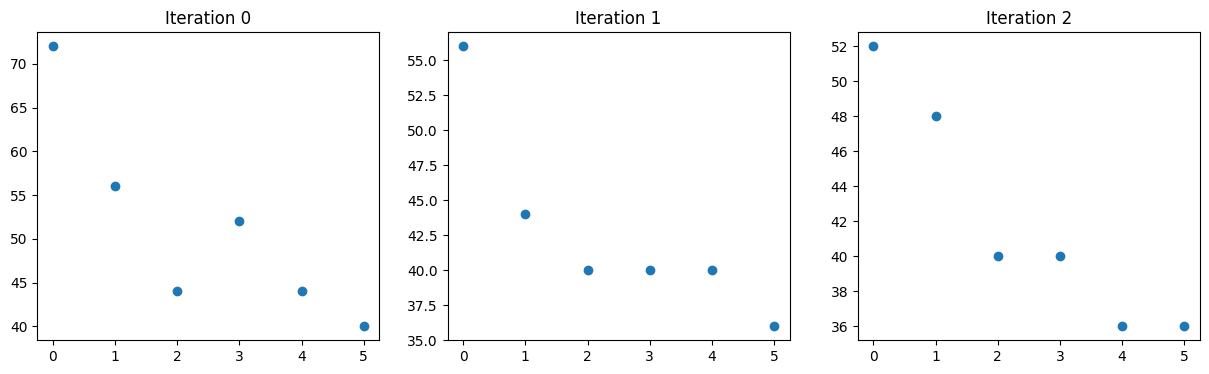

In [20]:
fig, axs = plt.subplots(ncols=n_iterations, figsize=(15,4))
for i, scores in enumerate(metrics):
    axs[i].scatter(x=[k for k in scores], y=[scores[k] for k in scores])
    axs[i].set_title(f"Iteration {i}")